# Titanic Disaster - Binary Classification - Logistic Regression

## Introduction

This is an example of a **Binary Classification** algorithm. For this project, I have leveraged Logistic Regression. Additional popular algorithms for Binary Classification include:

* k-Nearest Neighbors
* Decision Trees
* Support Vector Machine
* Naive Bayes


## Importing Data Science Libraries

In [548]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Data Cleansing

#### Importing the Datasets

In [549]:
trainDF = pd.read_csv('/Users/ryancarrell/Desktop/titanic/train.csv')
testDF = pd.read_csv('/Users/ryancarrell/Desktop/titanic/test.csv')

In [550]:
print(trainDF.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Based on the output, the following columns are possible explanatory variables:

* Pclass (Ticket class; Key: 1 = 1st, 2 = 2nd, 3 = 3rd)
* Name (Name of passenger)
* Sex (Sex)
* Age (Age in years)
* SibSp (# of siblings / spouses aboard the Titanic)
* Parch (# of parents / children aboard the Titanic)
* Ticket (Ticket number)
* Fare (Passenger fare)
* Cabin (Cabin number)
* Embarked (Port of Embarkation; Key: C = Cherbourg, Q = Queenstown, S = Southampton)

Here is an example of the data contained in this dataset:

In [551]:
trainDF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [552]:
trainDF['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [553]:
trainDF['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Text(0, 0.5, 'Number of Survivors')

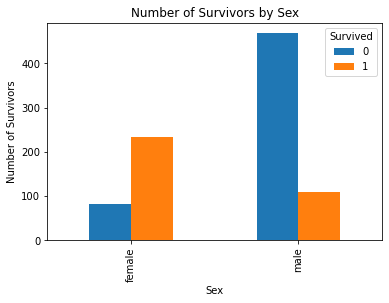

In [554]:
pd.crosstab(trainDF['Sex'], trainDF['Survived']).plot(kind='bar')
plt.title('Number of Survivors by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Survivors')

Text(0, 0.5, 'Number of Survivors')

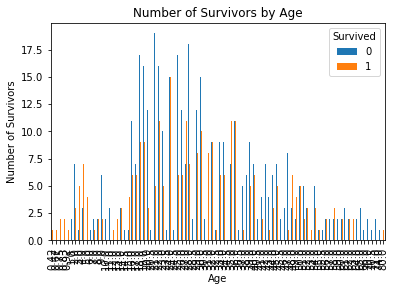

In [555]:
pd.crosstab(trainDF['Age'], trainDF['Survived']).plot(kind='bar')
plt.title('Number of Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Number of Survivors')

Text(0, 0.5, 'Number of Survivors')

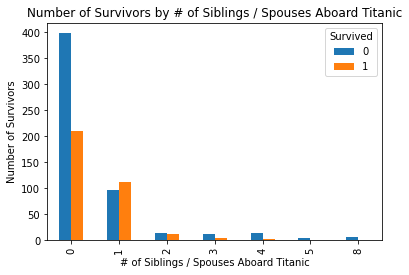

In [556]:
pd.crosstab(trainDF['SibSp'], trainDF['Survived']).plot(kind='bar')
plt.title('Number of Survivors by # of Siblings / Spouses Aboard Titanic')
plt.xlabel('# of Siblings / Spouses Aboard Titanic')
plt.ylabel('Number of Survivors')

In [557]:
#Update 'Sex' variable to floats for model input
trainDF['Sex'].mask(trainDF['Sex'] == 'male', 0, inplace=True)
trainDF['Sex'].mask(trainDF['Sex'] == 'female', 1, inplace=True)
testDF['Sex'].mask(testDF['Sex'] == 'male', 0, inplace=True)
testDF['Sex'].mask(testDF['Sex'] == 'female', 1, inplace=True)

#Update 'Embarked' variable to floats for model input
trainDF['Embarked'].mask(trainDF['Embarked'] == 'S', 0, inplace=True)
trainDF['Embarked'].mask(trainDF['Embarked'] == 'C', 1, inplace=True)
trainDF['Embarked'].mask(trainDF['Embarked'] == 'Q', 2, inplace=True)
testDF['Embarked'].mask(testDF['Embarked'] == 'S', 0, inplace=True)
testDF['Embarked'].mask(testDF['Embarked'] == 'C', 1, inplace=True)
testDF['Embarked'].mask(testDF['Embarked'] == 'Q', 2, inplace=True)

In [572]:
#Check for percentage of NaN values in 'Cabin'

print(trainDF['Cabin'].isna().sum())
print(len(trainDF['Cabin']))
print(687/891)

#trainDF['Room Number'] = trainDF['Cabin'].astype(int).str[1:]

687
891
0.7710437710437711


The 'Cabin' variable is missing a majority of its values. This is a tricky variable to drop, as Titanic historians would argue the 'Cabin' value -- and, in particular, the deck level -- would have a lot of bearing on the survival likelihood of a passenger. This is because certain deck levels were locked off during the sinking of the ship, and other decks were difficult to navigate, depending on what amenities and / or common areas were present on that level.

Theoretically, the 'Cabin' NaN values could be fixed as follows:

* Split 'Cabin' into two columns - 'Deck Level' and 'Room Number'
* Convert the 'Deck Level' to corresponding numerical values
* Take the floor of the average of the 'Deck Level' values to determine a replacement value for 'Deck Level' NaN values
* Take the floor of the average of the 'Room Number' values to determine a replacement value for 'Room Number' NaN values

However, this is a very simplistic approach to estimating Cabin assignment across the ship, and as Cabin assignment would be heavily randomized once bucketed by class (i.e. 1st class was on upper decks but throughout the length of the ship), this wouldn't provide much additional information.

In [559]:
print(trainDF['Pclass'].isna().sum())
print(trainDF['Sex'].isna().sum())
print(trainDF['Age'].isna().sum())
print(trainDF['SibSp'].isna().sum())
print(trainDF['Parch'].isna().sum())
print(trainDF['Fare'].isna().sum())
print(trainDF['Embarked'].isna().sum())

0
0
177
0
0
0
2


In [560]:
#Calculate average age of first class passengers
avgAge1stTrain = trainDF.loc[trainDF['Pclass'] == 1]['Age'].mean()
trainDF.loc[trainDF['Pclass'] == 1, 'Age'] = trainDF.loc[trainDF['Pclass'] == 1, 'Age'].fillna(avgAge1stTrain)

#Calculate average age of second class passengers
avgAge2ndTrain = trainDF[trainDF['Pclass'] == 2]['Age'].mean()
trainDF.loc[trainDF['Pclass'] == 2, 'Age'] = trainDF.loc[trainDF['Pclass'] == 2, 'Age'].fillna(avgAge2ndTrain)

#Calculate average age of third class passengers
avgAge3rdTrain = trainDF[trainDF['Pclass'] == 3]['Age'].mean()
trainDF.loc[trainDF['Pclass'] == 3, 'Age'] = trainDF.loc[trainDF['Pclass'] == 3, 'Age'].fillna(avgAge3rdTrain)

In [561]:
#Replace NaN in 'Embarked' with values
trainDF.loc[:, 'Embarked'] = trainDF.loc[:, 'Embarked'].fillna('1')

In [562]:
print(testDF['Pclass'].isna().sum())
print(testDF['Sex'].isna().sum())
print(testDF['Age'].isna().sum())
print(testDF['SibSp'].isna().sum())
print(testDF['Parch'].isna().sum())
print(testDF['Fare'].isna().sum())
print(testDF['Embarked'].isna().sum())

0
0
86
0
0
1
0


The age of a passenger would likely vary based on 'Pclass'. Thus, we will replace the NaN 'Age' values with the average age of passengers bucketed by 'Pclass'.

In [563]:
#Calculate average age of first class passengers
avgAge1stTest = testDF.loc[testDF['Pclass'] == 1]['Age'].mean()
testDF.loc[testDF['Pclass'] == 1, 'Age'] = testDF.loc[testDF['Pclass'] == 1, 'Age'].fillna(avgAge1stTest)

#Calculate average age of second class passengers
avgAge2ndTest = testDF[testDF['Pclass'] == 2]['Age'].mean()
testDF.loc[testDF['Pclass'] == 2, 'Age'] = testDF.loc[testDF['Pclass'] == 2, 'Age'].fillna(avgAge2ndTest)

#Calculate average age of third class passengers
avgAge3rdTest = testDF[testDF['Pclass'] == 3]['Age'].mean()
testDF.loc[testDF['Pclass'] == 3, 'Age'] = testDF.loc[testDF['Pclass'] == 3, 'Age'].fillna(avgAge3rdTest)

In [564]:
#Identify class of passenger and calculate average fare 
nullFares = testDF[testDF['Fare'].isnull()]
passengerClass = nullFares.values[0][1]
testDF.loc[testDF['Pclass'] == passengerClass, 'Fare'] = testDF.loc[testDF['Pclass'] == passengerClass, 'Fare'].fillna(avgFare)

## Building & Executing Linear Regression Model

Note: I haven't added any scaling to the dataset. Without scaling, the Logistic Regression algorithm may not be able to correctly converge. However, one way to resolve this is by increasing the number of iterations of the algorithm from '100' to '1000'. This is how I have handled this particular scenario. Other options may include:

* Trying a different optimizer
* Scaling the data
* Adding engineered features
* Additional data pre-processing
* Adding more data

#### Model & Prediction Results

Note: Splitting of variables can also happen with the train_test_split function from sklearn.crossvalidation.

In [565]:
#Create train and test datasets
trainSize = len(trainDF)*.80
trainDataset = trainDF.sample(int(trainSize))
testDataset = trainDF[~trainDF.index.isin(trainDataset.index)]

trainX = trainDataset[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy() #Identify features for inclusion
trainY = trainDataset[['Survived']].copy() #Target Variable

testX = testDataset[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()
testY = testDataset[['Survived']].copy() #Target Variable

#Instantiate model with default parameters
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

#Fit model with training data
logreg.fit(trainX, trainY.values.ravel())

#Import training dataset and calculate predictions
testResults = logreg.predict(testX)

print(testResults)
print(testY.values.ravel())

[1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0
 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1
 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0
 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1]
[0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0
 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1
 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1]


#### Model Evaluation Using Confusion Matrix

In [566]:
confusionMatrix = metrics.confusion_matrix(testY.values.ravel(), testResults)
confusionMatrix

array([[95, 12],
       [21, 51]])

Text(0.5, 257.44, 'Predicted Survival Classification')

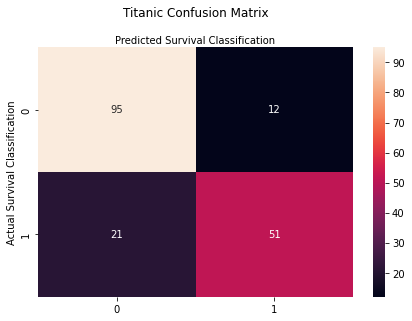

In [567]:
class_names = ['Not Survived', 'Survived'] # Name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Create Heatmap
sns.heatmap(pd.DataFrame(confusionMatrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Titanic Confusion Matrix', y=1.1)
plt.ylabel('Actual Survival Classification')
plt.xlabel('Predicted Survival Classification')

#### Model Accuracy, Precision, & Recall

We will now check the model for its accuracy, precision, and recall. These terms can be defined as follows:

* **Accuracy:** The proportion of true results among the total number of cases examined.
* **Precision:** The proportion of predicted 'Survived' values that are truly 'Survived'.
* **Recall:** The proportion of truly 'Survived' values that have been accurately classified by the model.


In [568]:
print("Accuracy:", metrics.accuracy_score(testY.values.ravel(), testResults))
print("Precision:", metrics.precision_score(testY.values.ravel(), testResults))
print("Recall:", metrics.recall_score(testY.values.ravel(), testResults))

Accuracy: 0.8156424581005587
Precision: 0.8095238095238095
Recall: 0.7083333333333334


## Check for Multicollinearity

#### Check Pearson's Correlation Coefficient

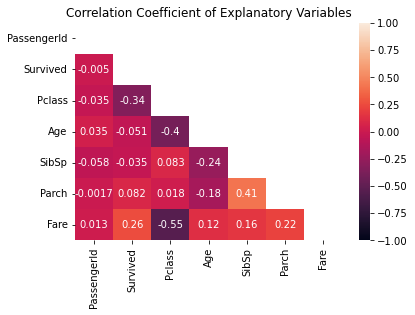

In [569]:
triangleMask = np.triu(np.ones_like(trainDF.corr(), dtype=bool))
sns.heatmap(trainDF.corr(), annot=True, mask = triangleMask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient of Explanatory Variables')
plt.show()

## Run Model on Kaggle Test Set

#### Run Model on Test Dataset

In [570]:
# Create Dataframe with data for submission
submissionData = testDF[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

# Run model on submission dataset
submissionResults = logreg.predict(submissionData)
submissionResults

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

#### Create Submission File

In [571]:
submissionFile = pd.DataFrame({'PassengerId' : testDF.values[:,0], 'Survived' : submissionResults })
submissionFile.to_csv("titanic-submission-binary classification.csv", index=False)